# **DIABETIC RETINOPATHY DETECTION**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob

%matplotlib inline 

In [3]:
# copy the weights and configurations for the pre-trained models

!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [7]:
import os
base_image_dir = os.path.join('.', '/content/drive/MyDrive/Deep Learning Lab Sem - V/DL - MINI PROJECT/Sample_data_10000')
df = pd.read_csv(os.path.join('/content/drive/MyDrive/Deep Learning Lab Sem - V/DL - MINI PROJECT/trainLabels_cropped.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) 
# Most of the files do not exist because this is a sample of the original dataset

df = df[df['exists']]
print(df[df['exists']])
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)     # Shuffle Dataframe
df['level'] = df['level'].astype(str)
df.head(10)

       Unnamed: 0  Unnamed: 0.1        image  level  \
0               0             0      10_left      0   
1               1             1     10_right      0   
2               2             2      13_left      0   
3               3             3     13_right      0   
4               4             4      15_left      1   
...           ...           ...          ...    ...   
10183       10183         10190   12838_left      0   
10184       10184         10191  12838_right      0   
10185       10185         10192   12839_left      2   
10186       10186         10193  12839_right      2   
10187       10187         10194   12842_left      0   

                                                    path  exists  
0      /content/drive/MyDrive/Deep Learning Lab Sem -...    True  
1      /content/drive/MyDrive/Deep Learning Lab Sem -...    True  
2      /content/drive/MyDrive/Deep Learning Lab Sem -...    True  
3      /content/drive/MyDrive/Deep Learning Lab Sem -...    True  
4   

,Unnamed: 0,Unnamed: 0.1,level,path
0,7771,7777,0,/content/drive/MyDrive/Deep Learning Lab Sem -...
1,3395,3399,0,/content/drive/MyDrive/Deep Learning Lab Sem -...
2,9735,9742,1,/content/drive/MyDrive/Deep Learning Lab Sem -...
3,5466,5470,3,/content/drive/MyDrive/Deep Learning Lab Sem -...
4,2688,2691,0,/content/drive/MyDrive/Deep Learning Lab Sem -...
5,3783,3787,0,/content/drive/MyDrive/Deep Learning Lab Sem -...
6,1947,1950,0,/content/drive/MyDrive/Deep Learning Lab Sem -...
7,4176,4180,0,/content/drive/MyDrive/Deep Learning Lab Sem -...
8,6284,6288,2,/content/drive/MyDrive/Deep Learning Lab Sem -...
9,3299,3303,0,/content/drive/MyDrive/Deep Learning Lab Sem -...


In [8]:
df['level'].value_counts()

0    7396
2    1622
1     740
3     242
4     188
Name: level, dtype: int64

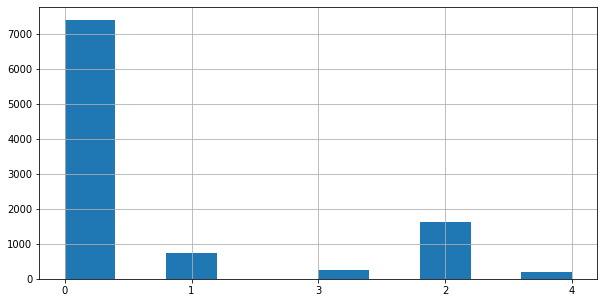

In [9]:
df['level'].hist(figsize = (10, 5))

In [10]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

2038

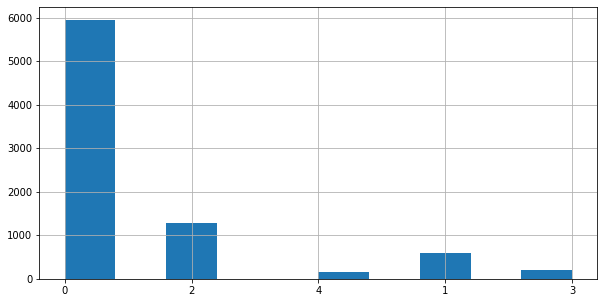

In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) 
# Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

New Data Size: 29730 Old Size: 8150


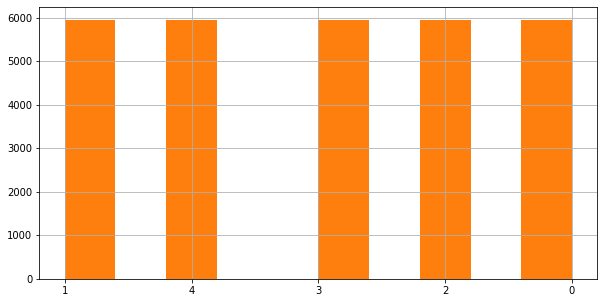

In [12]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) 
# Oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [13]:
train_df['level'].value_counts()

1    5946
4    5946
3    5946
2    5946
0    5946
Name: level, dtype: int64

In [14]:
df = pd.concat([train_df,val_df]) 
# Beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

31768

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [17]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 29730 validated image filenames belonging to 5 classes.
Found 2038 validated image filenames belonging to 5 classes.


In [18]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [19]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
t_x, t_y = next(x_train)

In [21]:
import tensorflow

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [22]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [23]:
from keras.layers import LeakyReLU


alexNet = tf.keras.Sequential()
alexNet.add(tf.keras.layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=t_x.shape[1:]))
# alexNet.add(tf.keras.Input(shape=[227, 227, 3]))
alexNet.add(tf.keras.layers.BatchNormalization(momentum  = 0.93, epsilon = 0.001))
alexNet.add(tf.keras.layers.Conv2D(filters = 96, kernel_size = 11, strides = 4, padding = "valid", kernel_regularizer = tf.keras.regularizers.l2(), name = "ConvLayer1"))
alexNet.add(tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, name = "MaxPoolLayer1"))
alexNet.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, activation = LeakyReLU(alpha=0.25), padding = "same", kernel_regularizer=tf.keras.regularizers.l2(), name = "ConvLayer2"))
alexNet.add(tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, name = "MaxPoolLayer2"))
alexNet.add(tf.keras.layers.BatchNormalization(momentum  = 0.93, epsilon = 0.001))
alexNet.add(tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, activation = LeakyReLU(alpha=0.25), padding = "same", kernel_regularizer = tf.keras.regularizers.l2(), name = "ConvLayer3"))
alexNet.add(tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, activation = LeakyReLU(alpha=0.25), padding = "same", kernel_regularizer = tf.keras.regularizers.l2(), name = "ConvLayer4"))
alexNet.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, activation = LeakyReLU(alpha=0.25), padding = "same", kernel_regularizer = tf.keras.regularizers.l2(), name = "ConvLayer5"))
alexNet.add(tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, name = "MaxPoolLayer3"))
alexNet.add(tf.keras.layers.Flatten())
alexNet.add(tf.keras.layers.BatchNormalization(momentum  = 0.93, epsilon = 0.001))
alexNet.add(tf.keras.layers.Dense(4096, activation = LeakyReLU(alpha=0.25), kernel_regularizer = tf.keras.regularizers.l2(), name = "HiddenLayer1"))
alexNet.add(tf.keras.layers.Dropout(0.8))
alexNet.add(tf.keras.layers.Dense(4096, activation = LeakyReLU(alpha=0.25), kernel_regularizer = tf.keras.regularizers.l2(), name = "HiddenLayer2"))
alexNet.add(tf.keras.layers.Dropout(0.6))
alexNet.add(tf.keras.layers.Dense(5, activation = "softmax", name = "OutputLayer"))
optmzr = tf.keras.optimizers.Adam(learning_rate = 0.0001)

from keras.metrics import top_k_categorical_accuracy

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)


alexNet.compile(loss = "categorical_crossentropy", optimizer = optmzr, metrics = ['categorical_accuracy', top_2_accuracy])
alexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 ConvLayer1 (Conv2D)         (None, 54, 54, 96)        34944     
                                                                 
 MaxPoolLayer1 (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 ConvLayer2 (Conv2D)         (None, 26, 26, 256)       614656    
                                                                 
 MaxPoolLayer2 (MaxPooling2D  (None, 12, 12, 256)      0

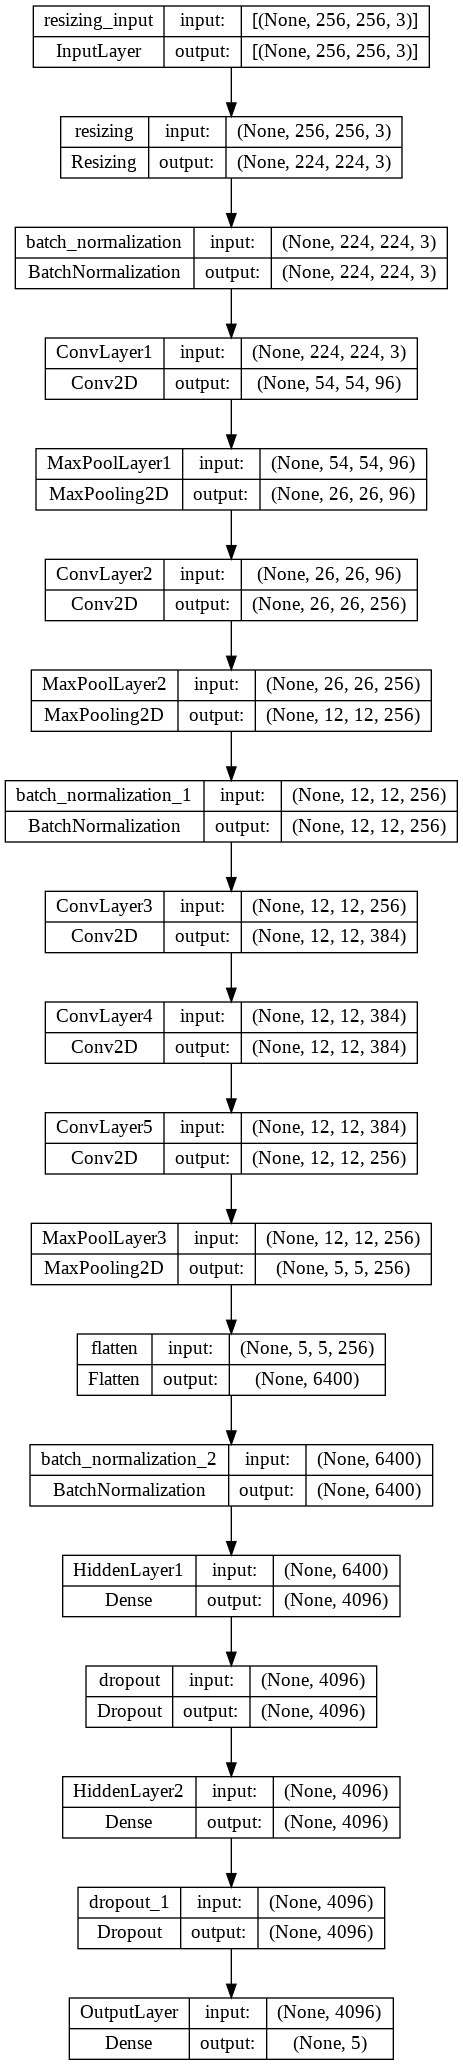

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(alexNet, show_shapes=True, show_layer_names=True)

In [25]:
history_an = alexNet.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs = 15,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)

alexNet.save_weights("dr_messidor_an.h5")

Epoch 1/15
464/464 [==============================] - ETA: 0s - loss: 97.8699 - categorical_accuracy: 0.2011 - top_2_accuracy: 0.4085

464/464 [==============================] - 1964s 4s/step - loss: 97.8699 - categorical_accuracy: 0.2011 - top_2_accuracy: 0.4085 - val_loss: 86.7978 - val_categorical_accuracy: 0.1603 - val_top_2_accuracy: 0.3518 - lr: 1.0000e-04
Epoch 2/15
464/464 [==============================] - ETA: 0s - loss: 81.0917 - categorical_accuracy: 0.2099 - top_2_accuracy: 0.4085

464/464 [==============================] - 800s 2s/step - loss: 81.0917 - categorical_accuracy: 0.2099 - top_2_accuracy: 0.4085 - val_loss: 71.2199 - val_categorical_accuracy: 0.3095 - val_top_2_accuracy: 0.6391 - lr: 1.0000e-04
Epoch 3/15
464/464 [==============================] - ETA: 0s - loss: 65.4542 - categorical_accuracy: 0.2132 - top_2_accuracy: 0.4144

464/464 [==============================] - 566s 1s/step - loss: 65.4542 - categorical_accuracy: 0.2132 - top_2_accuracy: 0.4144 - val_loss: 57.0472 - val_categorical_accuracy: 0.1522 - val_top_2_accuracy: 0.4536 - lr: 1.0000e-04
Epoch 4/15
464/464 [==============================] - ETA: 0s - loss: 51.3066 - categorical_accuracy: 0.2126 - top_2_accuracy: 0.4170

464/464 [==============================] - 490s 1s/step - loss: 51.3066 - categorical_accuracy: 0.2126 - top_2_accuracy: 0.4170 - val_loss: 43.9734 - val_categorical_accuracy: 0.4728 - val_top_2_accuracy: 0.6663 - lr: 1.0000e-04
Epoch 5/15
464/464 [==============================] - ETA: 0s - loss: 38.9414 - categorical_accuracy: 0.2195 - top_2_accuracy: 0.4241

464/464 [==============================] - 462s 995ms/step - loss: 38.9414 - categorical_accuracy: 0.2195 - top_2_accuracy: 0.4241 - val_loss: 33.0131 - val_categorical_accuracy: 0.1522 - val_top_2_accuracy: 0.4546 - lr: 1.0000e-04
Epoch 6/15
464/464 [==============================] - ETA: 0s - loss: 28.4893 - categorical_accuracy: 0.2273 - top_2_accuracy: 0.4448

464/464 [==============================] - 440s 948ms/step - loss: 28.4893 - categorical_accuracy: 0.2273 - top_2_accuracy: 0.4448 - val_loss: 23.6415 - val_categorical_accuracy: 0.2571 - val_top_2_accuracy: 0.5373 - lr: 1.0000e-04
Epoch 7/15
464/464 [==============================] - ETA: 0s - loss: 20.1147 - categorical_accuracy: 0.2290 - top_2_accuracy: 0.4427

464/464 [==============================] - 437s 942ms/step - loss: 20.1147 - categorical_accuracy: 0.2290 - top_2_accuracy: 0.4427 - val_loss: 16.3228 - val_categorical_accuracy: 0.3206 - val_top_2_accuracy: 0.7046 - lr: 1.0000e-04
Epoch 8/15
464/464 [==============================] - ETA: 0s - loss: 13.6817 - categorical_accuracy: 0.2661 - top_2_accuracy: 0.4792

464/464 [==============================] - 429s 925ms/step - loss: 13.6817 - categorical_accuracy: 0.2661 - top_2_accuracy: 0.4792 - val_loss: 11.0264 - val_categorical_accuracy: 0.2490 - val_top_2_accuracy: 0.5050 - lr: 1.0000e-04
Epoch 9/15
464/464 [==============================] - ETA: 0s - loss: 9.0197 - categorical_accuracy: 0.2986 - top_2_accuracy: 0.5192

464/464 [==============================] - 426s 918ms/step - loss: 9.0197 - categorical_accuracy: 0.2986 - top_2_accuracy: 0.5192 - val_loss: 7.1953 - val_categorical_accuracy: 0.3377 - val_top_2_accuracy: 0.5786 - lr: 1.0000e-04
Epoch 10/15
464/464 [==============================] - ETA: 0s - loss: 5.8354 - categorical_accuracy: 0.3363 - top_2_accuracy: 0.5589

464/464 [==============================] - 422s 908ms/step - loss: 5.8354 - categorical_accuracy: 0.3363 - top_2_accuracy: 0.5589 - val_loss: 4.6629 - val_categorical_accuracy: 0.4052 - val_top_2_accuracy: 0.6673 - lr: 1.0000e-04
Epoch 11/15
464/464 [==============================] - ETA: 0s - loss: 3.8889 - categorical_accuracy: 0.3576 - top_2_accuracy: 0.5880

464/464 [==============================] - 407s 877ms/step - loss: 3.8889 - categorical_accuracy: 0.3576 - top_2_accuracy: 0.5880 - val_loss: 3.3992 - val_categorical_accuracy: 0.1835 - val_top_2_accuracy: 0.4546 - lr: 1.0000e-04
Epoch 12/15
464/464 [==============================] - ETA: 0s - loss: 2.7963 - categorical_accuracy: 0.3872 - top_2_accuracy: 0.6161

464/464 [==============================] - 406s 874ms/step - loss: 2.7963 - categorical_accuracy: 0.3872 - top_2_accuracy: 0.6161 - val_loss: 2.4717 - val_categorical_accuracy: 0.3145 - val_top_2_accuracy: 0.6774 - lr: 1.0000e-04
Epoch 13/15
464/464 [==============================] - ETA: 0s - loss: 2.2376 - categorical_accuracy: 0.4122 - top_2_accuracy: 0.6489

464/464 [==============================] - 403s 869ms/step - loss: 2.2376 - categorical_accuracy: 0.4122 - top_2_accuracy: 0.6489 - val_loss: 2.5030 - val_categorical_accuracy: 0.2500 - val_top_2_accuracy: 0.5020 - lr: 1.0000e-04
Epoch 14/15
464/464 [==============================] - ETA: 0s - loss: 1.9865 - categorical_accuracy: 0.4540 - top_2_accuracy: 0.6810

464/464 [==============================] - 406s 876ms/step - loss: 1.9865 - categorical_accuracy: 0.4540 - top_2_accuracy: 0.6810 - val_loss: 2.3203 - val_categorical_accuracy: 0.1704 - val_top_2_accuracy: 0.4839 - lr: 1.0000e-04
Epoch 15/15
464/464 [==============================] - ETA: 0s - loss: 1.8481 - categorical_accuracy: 0.4928 - top_2_accuracy: 0.7144

464/464 [==============================] - 405s 873ms/step - loss: 1.8481 - categorical_accuracy: 0.4928 - top_2_accuracy: 0.7144 - val_loss: 2.0347 - val_categorical_accuracy: 0.3528 - val_top_2_accuracy: 0.6784 - lr: 1.0000e-04


In [26]:
train_score_an = alexNet.evaluate(x_train)
test_score_an = alexNet.evaluate(x_test)

64/64 [==============================] - 31s 485ms/step - loss: 2.0338 - categorical_accuracy: 0.3724 - top_2_accuracy: 0.6968


In [27]:
print("Final training categorical accuracy = {:.2f} , Final validation categorical accuracy = {:.2f}".format(train_score_an[1]*100, test_score_an[1]*100))
print("Final training Top 2 accuracy = {:.2f} , Final validation Top 2 accuracy = {:.2f}".format(train_score_an[2]*100, test_score_an[2]*100))
print("Final training loss = {:.2f} , Final validation loss = {:.2f}".format(train_score_an[0], test_score_an[0]))

Final training categorical accuracy = 51.73 , Final validation categorical accuracy = 37.24
Final training Top 2 accuracy = 73.80 , Final validation Top 2 accuracy = 69.68
Final training loss = 1.77 , Final validation loss = 2.03


In [28]:
history_an.history

{'loss': [97.86985778808594,
  81.09174346923828,
  65.4542007446289,
  51.306640625,
  38.94137191772461,
  28.489280700683594,
  20.11471176147461,
  13.681718826293945,
  9.01974105834961,
  5.835406303405762,
  3.888903856277466,
  2.79630708694458,
  2.237630605697632,
  1.986477017402649,
  1.848068118095398],
 'categorical_accuracy': [0.20110675692558289,
  0.20987987518310547,
  0.21318666636943817,
  0.21262122690677643,
  0.2194628119468689,
  0.22730334103107452,
  0.22898706793785095,
  0.26609528064727783,
  0.2986260652542114,
  0.33634158968925476,
  0.35760560631752014,
  0.3872317373752594,
  0.4122440814971924,
  0.4540005326271057,
  0.49279364943504333],
 'top_2_accuracy': [0.4084896743297577,
  0.4084896743297577,
  0.41442838311195374,
  0.4169585108757019,
  0.42414629459381104,
  0.44477370381355286,
  0.4426858723163605,
  0.47921445965766907,
  0.519194483757019,
  0.5588631629943848,
  0.5880010724067688,
  0.6160750389099121,
  0.6489089727401733,
  0.681034

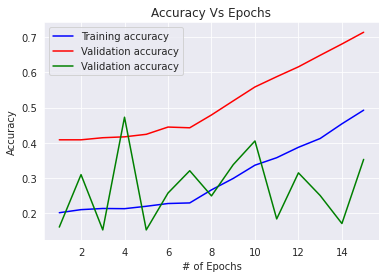

<Figure size 1080x1080 with 0 Axes>

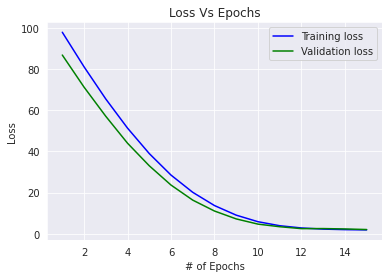

In [29]:
import seaborn as sb

sb.set_style("darkgrid")

Categorical_Acuracy_an = history_an.history['categorical_accuracy']
Top_2_Accuracy_an = history_an.history['top_2_accuracy']
Val_Categorical_Accuracy_an = history_an.history['val_categorical_accuracy']

Loss_an = history_an.history['loss']
Val_Loss_an = history_an.history['val_loss']

Epochs_an = range(1, len(Categorical_Acuracy_an) + 1)

#Train and validation accuracy

plt.plot(Epochs_an, Categorical_Acuracy_an, 'b', label='Training accuracy')
plt.plot(Epochs_an, Top_2_Accuracy_an, 'r', label='Validation accuracy')
plt.plot(Epochs_an, Val_Categorical_Accuracy_an, 'g', label='Validation accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()

plt.figure(figsize = (15, 15))
plt.show()

print("\n\n")

#Train and validation loss

plt.plot(Epochs_an, Loss_an, 'b', label='Training loss')
plt.plot(Epochs_an, Val_Loss_an, 'g', label='Validation loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs Epochs')
plt.legend()

plt.show()

In [30]:
y_pred_an = alexNet.predict(x_train)
y_pred_an = np.argmax(y_pred_an, axis=1)
class_labels_an = x_test.class_indices
class_labels_an = {v:k for k,v in class_labels_an.items()}

930/930 [==============================] - 758s 815ms/step


In [31]:
y_pred_an

array([0, 3, 4, ..., 1, 4, 3])

Confusion Matrix:

[[1448 1025  697 1459 1317]
 [1467 1004  701 1519 1255]
 [1423 1027  704 1487 1305]
 [1456  987  696 1491 1316]
 [1434 1001  692 1483 1336]]

Classification Report:

              precision    recall  f1-score   support

           0       0.20      0.24      0.22      5946
           1       0.20      0.17      0.18      5946
           2       0.20      0.12      0.15      5946
           3       0.20      0.25      0.22      5946
           4       0.20      0.22      0.21      5946

    accuracy                           0.20     29730
   macro avg       0.20      0.20      0.20     29730
weighted avg       0.20      0.20      0.20     29730



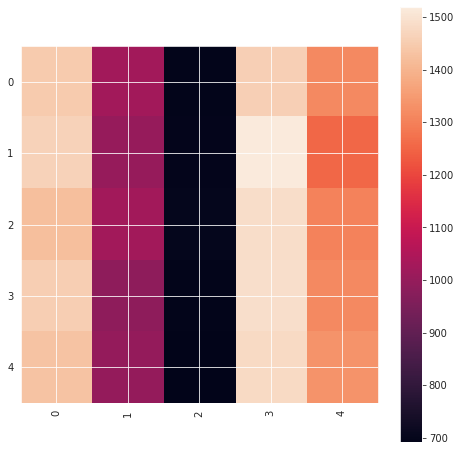

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

cm_train_an = confusion_matrix(x_train.classes, y_pred_an)
print('Confusion Matrix:\n')
print(cm_train_an)
print('\nClassification Report:\n')
target_names_an = list(class_labels_an.values())
print(classification_report(x_train.classes, y_pred_an, target_names=target_names_an))

plt.figure(figsize=(8,8))
plt.imshow(cm_train_an, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names_an))
_ = plt.xticks(tick_mark, target_names_an, rotation=90)
_ = plt.yticks(tick_mark, target_names_an)